### Mouse Protein dataset visualization

The 'Data_Cortex_Nuclear.csv' dataset is from the **abidlabs/contrastive** Github repository: https://github.com/abidlabs/contrastive/blob/master/experiments/datasets/Data_Cortex_Nuclear.csv

In [5]:
%pip install contrastive-inverse-regression

CIR......


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


---------------------------------------------------

Results for Scaled Gradient Projection Method 

---------------------------------------------------

   Obj. function = 2.411598e+00

   Gradient norm = 6.752662e-04 

   ||X^T*X-I||_F = 8.01e-16

   Iteration number = 3000

   Cpu time (secs) = 8.2385

   Number of evaluation(Obj. func) = 3495

SIR...
PCA...
CPCA...
t-SNE...
UMAP...
LDA...
LASSO...


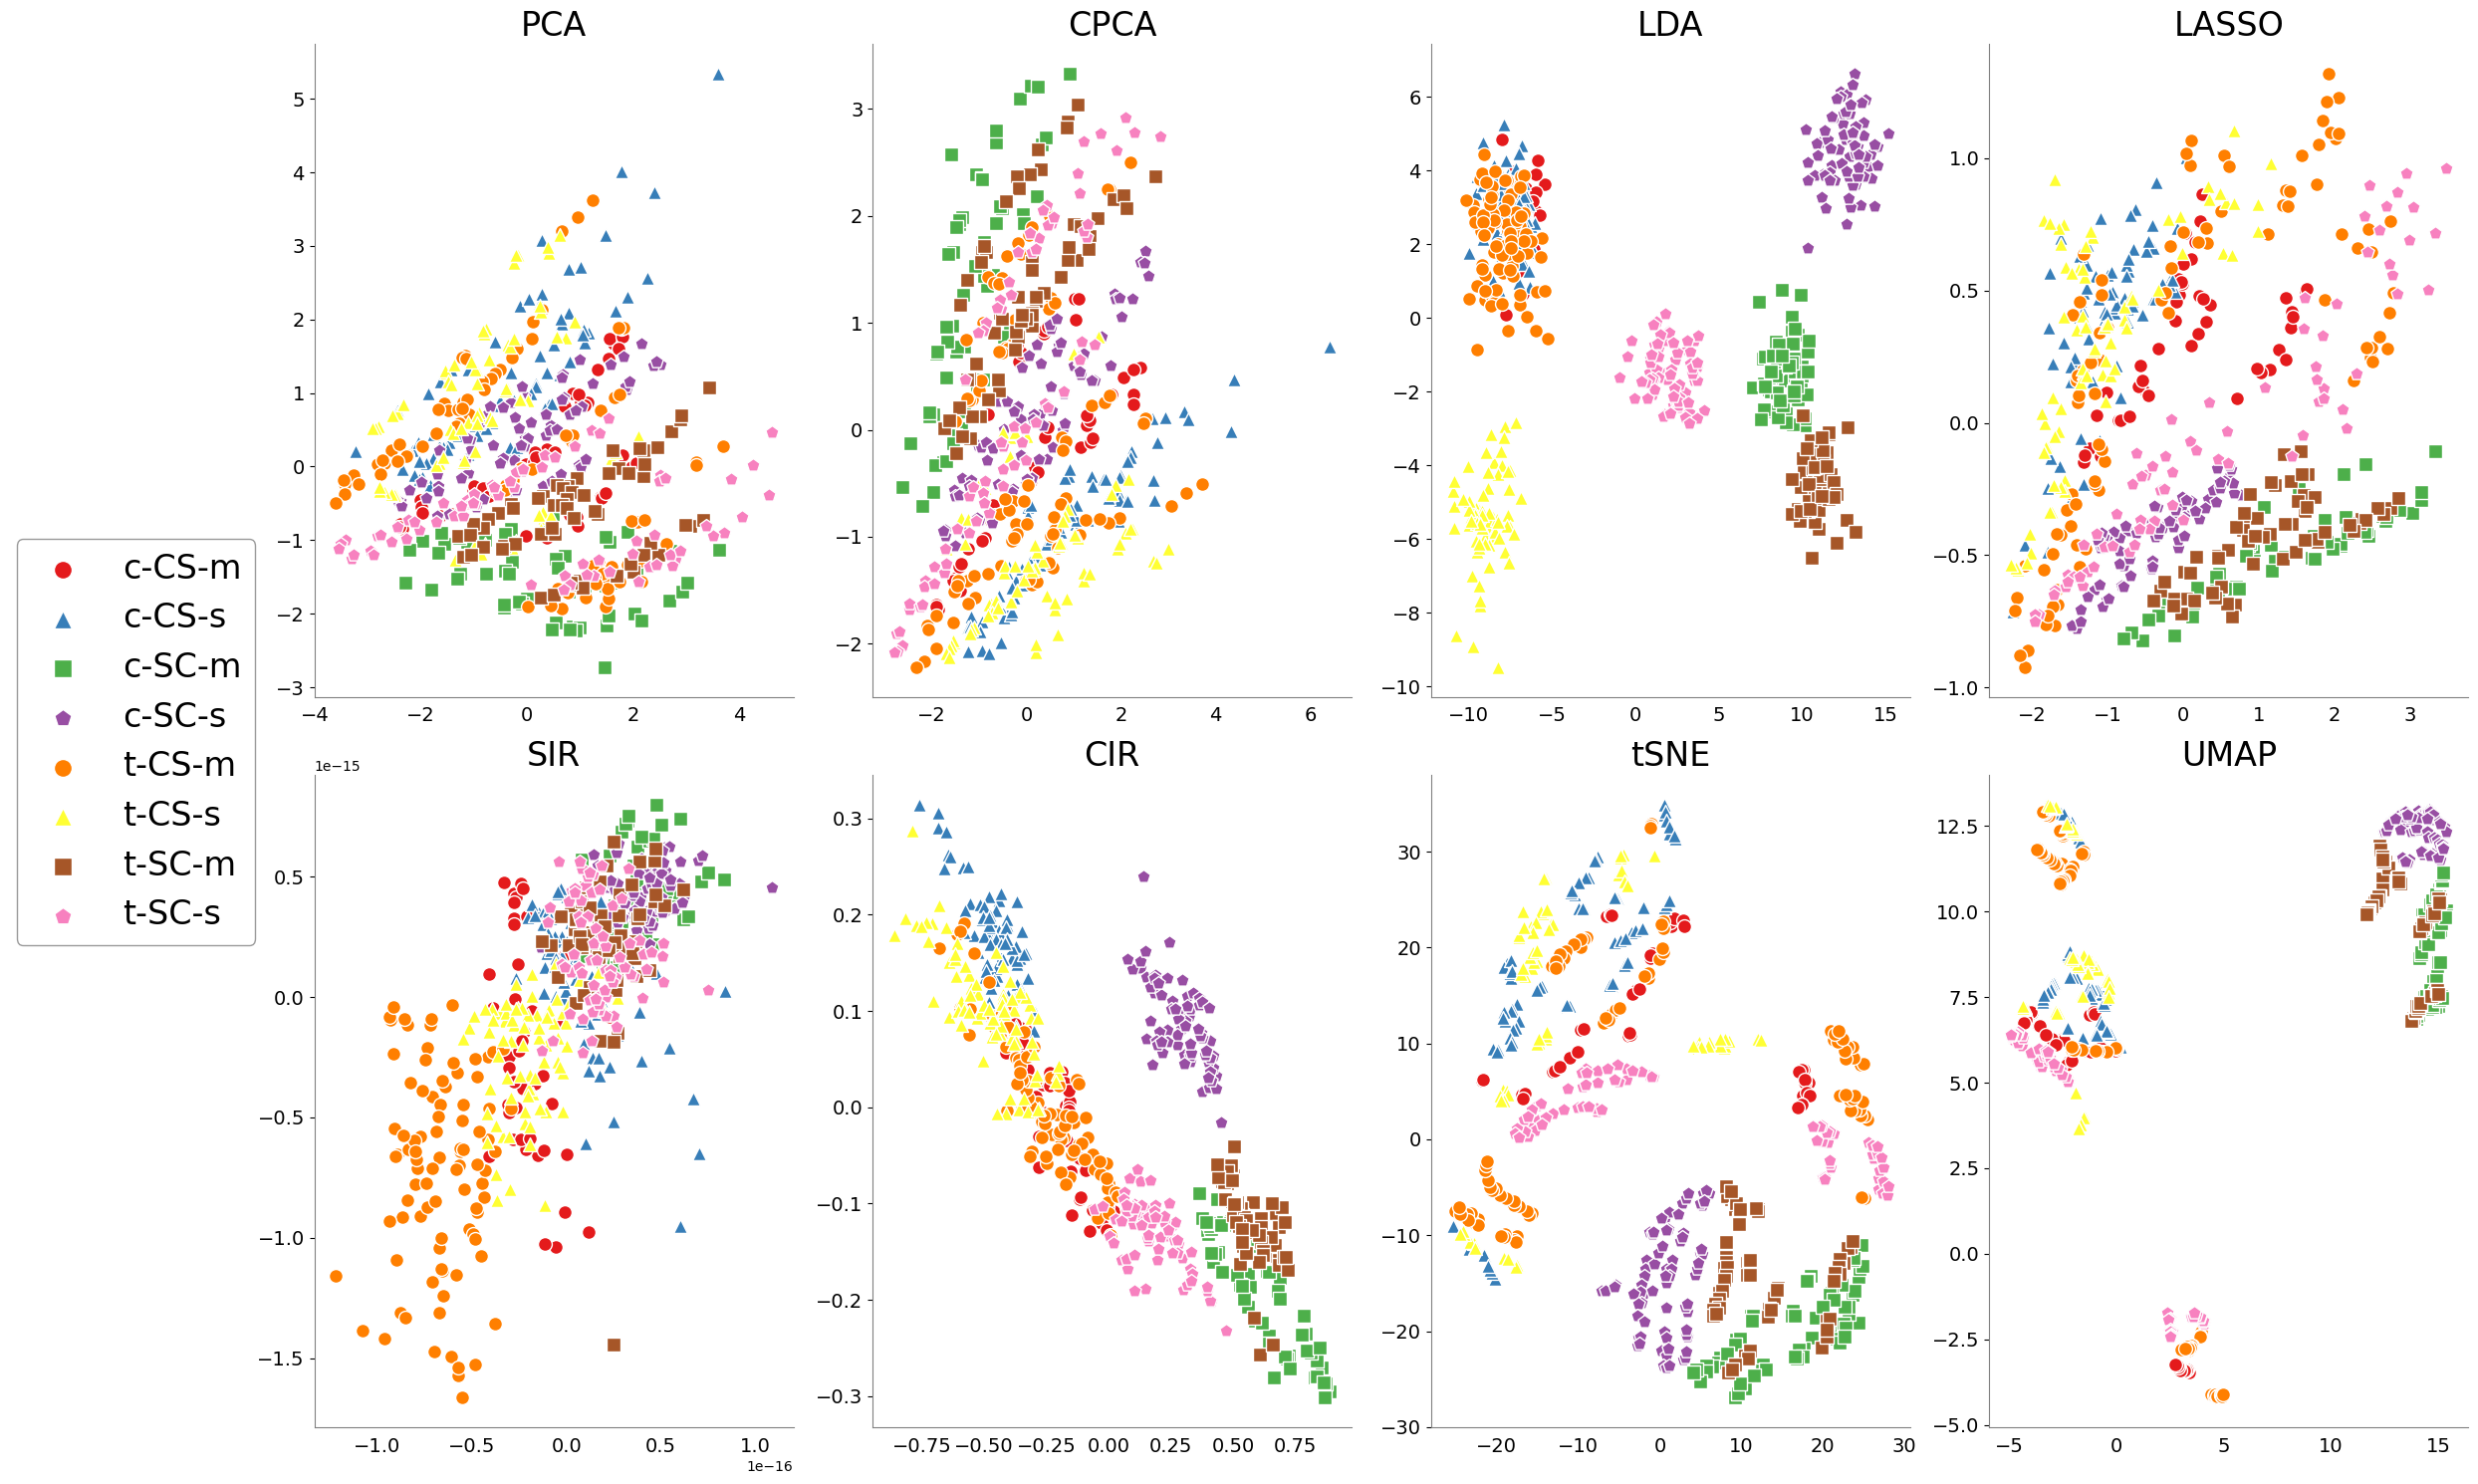

  Method  Silhouette Score  Calinski-Harabasz Score  Davies Bouldin Score
0    PCA         -0.106114                21.361620              7.702425
1   CPCA         -0.070211                30.288295              8.619097
2    LDA          0.416656              3530.882835              1.606846
3  LASSO         -0.114486                44.091642             11.022367
4    SIR         -0.108238               148.577770              0.000000
5    CIR          0.139336               704.851420              2.901126
6   tSNE          0.005671                89.632250              4.385883
7   UMAP          0.008745               272.671514              6.567486


In [31]:
import numpy as np
import pandas as pd
import time
import matplotlib
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.metrics import silhouette_score
from scipy.linalg import eig
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import contrastive_inverse_regression
from contrastive_inverse_regression import CIR


data = pd.read_csv('datasets/Data_Cortex_Nuclear.csv')


# foreground data
fg = data.dropna()


# foreground label
Y = fg['class']
Y = pd.Categorical(Y)
Y = Y.rename_categories({'c-CS-m': '0', 'c-CS-s': '1', 'c-SC-m': '2', 'c-SC-s': '3',
                        't-CS-m': '4', 't-CS-s': '5', 't-SC-m': '6', 't-SC-s': '7'})
Y = Y.astype(float)
labels = np.unique(Y)      # set of unique foreground labels
L = len(labels)         # number of foreground classes/slices
fg = fg.iloc[:, 1:78]
n = fg.shape[0]  # foreground sample size
X = fg - np.mean(fg, axis=0)
X = X.values


# background data
bg = data[data['Genotype'] == 'Control'].copy()
bg = bg.dropna()


# background label
Yt = bg['Behavior']
Yt = pd.Categorical(Yt)
Yt = Yt.rename_categories({'C/S': '0', 'S/C': '1'})


Yt = Yt.astype(float)
labelst = np.unique(Yt)   # set of unique background labels
Lt = len(labelst)       # number of background classes/slices
bg = bg.iloc[:, 1:78]
m, p = bg.shape


# tuning parameter alpha
alpha = 0.0001
# reduce dimension from 77 to 2 for visualization
d = 2


np.random.seed(42)      # add seed


# CIR
print("CIR......")
start_time = time.time()


V_CIR = CIR(fg, Y, bg, Yt, alpha, d)
X_CIR = X @ V_CIR


end_time = time.time()



# SIR
print("SIR...")
Sigma_XX = X.T @ X / n
Sigma_X = np.zeros((p, p))
for l in labels:
   X_curr = fg.values[Y == l]
   n_curr = X_curr.shape[0]
   Sigma_X += n_curr * np.outer(X_curr.mean(axis=0) - fg.values.mean(axis=0), X_curr.mean(axis=0) - fg.values.mean(axis=0))


Sigma_X /= n
eigvals, eigvecs = eig(Sigma_XX, Sigma_X)
V_SIR = eigvecs[:, :d]
X_SIR = X @ V_SIR



# PCA
print("PCA...")
pca = PCA(n_components=d)
X_PCA = pca.fit_transform(X)


# CPCA
print("CPCA...")
alpha_CPCA = 2
cov_fg = np.cov(fg.values, rowvar=False)
cov_bg = np.cov(bg.values, rowvar=False)
eigvals, eigvecs = eig(cov_fg - alpha_CPCA * cov_bg)
V_CPCA = eigvecs[:, :d]
X_CPCA = X @ V_CPCA


# t-SNE
print("t-SNE...")
tsne = TSNE(n_components=d)
X_tSNE = tsne.fit_transform(fg.values)


# UMAP
import umap
print("UMAP...")
umap_model = umap.UMAP(n_components=d)
X_UMAP = umap_model.fit_transform(fg.values)


# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
print("LDA...")
lda = LDA(n_components=d)
X_LDA = lda.fit_transform(X, Y)


# # LASSO
print("LASSO...")
lasso = Lasso(alpha=0.1)
lasso.fit(X, Y)
selected_features = np.where(lasso.coef_ != 0)[0][:d]
X_LASSO = X[:, selected_features]




# colors credit to Color Brewer
colors = [[228/255, 26/255, 28/255],
         [55/255, 126/255, 184/255],
         [77/255, 175/255, 74/255],
         [152/255, 78/255, 163/255],
         [255/255, 127/255, 0/255],
         [255/255, 255/255, 51/255],
         [166/255, 86/255, 40/255],
         [247/255, 129/255, 191/255]]


markers = ['o', '^', 's', 'p', 'o', '^', 's', 'p']
legend_labels = [
    'c-CS-m', 'c-CS-s', 'c-SC-m', 'c-SC-s', 
    't-CS-m', 't-CS-s', 't-SC-m', 't-SC-s'
]


fig, axs = plt.subplots(2, 4, figsize=(25, 15))


# Function to plot scatter subplots
def plot_scatter(ax, X, title, fontsize=32):
    for l in range(L):
       X_curr = X[Y == labels[l]]
       ax.scatter(X_curr[:, 0], X_curr[:, 1], 100, color=colors[l], marker=markers[l], label=f'Label {labels[l]}', edgecolors='w')
    
    ax.tick_params(axis='both', which='major', bottom=False, top=False, left=True, right=False,
                labelleft=True, labelbottom=True, labelsize=14)
    ax.set_title(title, fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')



# Plotting each subplot
plot_scatter(axs[0, 0], X_PCA, 'PCA', 24)
plot_scatter(axs[0, 1], X_CPCA, 'CPCA', 24)
plot_scatter(axs[0, 2], X_LDA, 'LDA', 24)
plot_scatter(axs[0, 3], X_LASSO, 'LASSO', 24)
plot_scatter(axs[1, 0], X_SIR, 'SIR', 24)
plot_scatter(axs[1, 1], X_CIR, 'CIR', 24)
plot_scatter(axs[1, 2], X_tSNE, 'tSNE', 24)
plot_scatter(axs[1, 3], X_UMAP, 'UMAP', 24)

# Create a legend
fig.legend(legend_labels, loc='center left', fontsize=24, markerscale=1.3, frameon=True, edgecolor='grey')

plt.tight_layout(rect=[0.1, 0, 1, 1])
plt.show()


# print('Silhouette scores for PCA, CPCA, LDA, LASSO, SIR, CIR, tSNE, UMAP')
silhouette_scores = [
   silhouette_score(X_PCA, Y),
   silhouette_score(X_CPCA, Y),
   silhouette_score(X_LDA, Y),
   silhouette_score(X_LASSO, Y),
   silhouette_score(X_SIR, Y),
   silhouette_score(X_CIR, Y),
   silhouette_score(X_tSNE, Y),
   silhouette_score(X_UMAP, Y),
]

# print('Calinski Harabasz scores for PCA, CPCA, LDA, LASSO, SIR, CIR, tSNE, UMAP')
calinski_harabasz_scores = [
    calinski_harabasz_score(X_PCA, Y),
    calinski_harabasz_score(X_CPCA, Y),
    calinski_harabasz_score(X_LDA, Y),
    calinski_harabasz_score(X_LASSO, Y),
    calinski_harabasz_score(X_SIR, Y),
    calinski_harabasz_score(X_CIR, Y),
    calinski_harabasz_score(X_tSNE, Y),
    calinski_harabasz_score(X_UMAP, Y),
]


# print('Davies Bouldin scores for PCA, CPCA, LDA, LASSO, SIR, CIR, tSNE, UMAP')
davies_bouldin_scores = [
    davies_bouldin_score(X_PCA, Y),
    davies_bouldin_score(X_CPCA, Y),
    davies_bouldin_score(X_LDA, Y),
    davies_bouldin_score(X_LASSO, Y),
    davies_bouldin_score(X_SIR, Y),
    davies_bouldin_score(X_CIR, Y),
    davies_bouldin_score(X_tSNE, Y),
    davies_bouldin_score(X_UMAP, Y),
]


methods = ['PCA', 'CPCA', 'LDA', 'LASSO', 'SIR', 'CIR', 'tSNE', 'UMAP']
scores_df = pd.DataFrame({
    'Method': methods,
    'Silhouette Score': silhouette_scores,
    'Calinski-Harabasz Score': calinski_harabasz_scores,
    'Davies Bouldin Score': davies_bouldin_scores, 
})


print(scores_df)